# Model 1: Facial key points detection

### STEP 1: Import libraries and datasets

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [3]:
# load facial key points data
keyfacial_df = pd.read_csv('/content/drive/My Drive/Summer2023UW/AI-projects/P96-Section-2-Emotion-AI/Emotion-AI-Dataset/data.csv')


In [4]:
# Obtain relavant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [5]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [6]:
keyfacial_df['Image'].shape

(2140,)

In [7]:
len(keyfacial_df['Image'][0].split(' '))

9216

In [8]:
import math

ncolumn = int(math.sqrt(len(keyfacial_df['Image'][0].split(' '))))

In [9]:
# Convert keyfacial_df['Image'] from string to a ncolumn*ncolumn 2-D array
# step 1: convert string to 1-D array
# step 2: reshape 1-D array to a 2-D array

keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(ncolumn, ncolumn))

In [10]:
keyfacial_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [11]:
# Describe keyfacial
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


## STEP 2: Data visualization

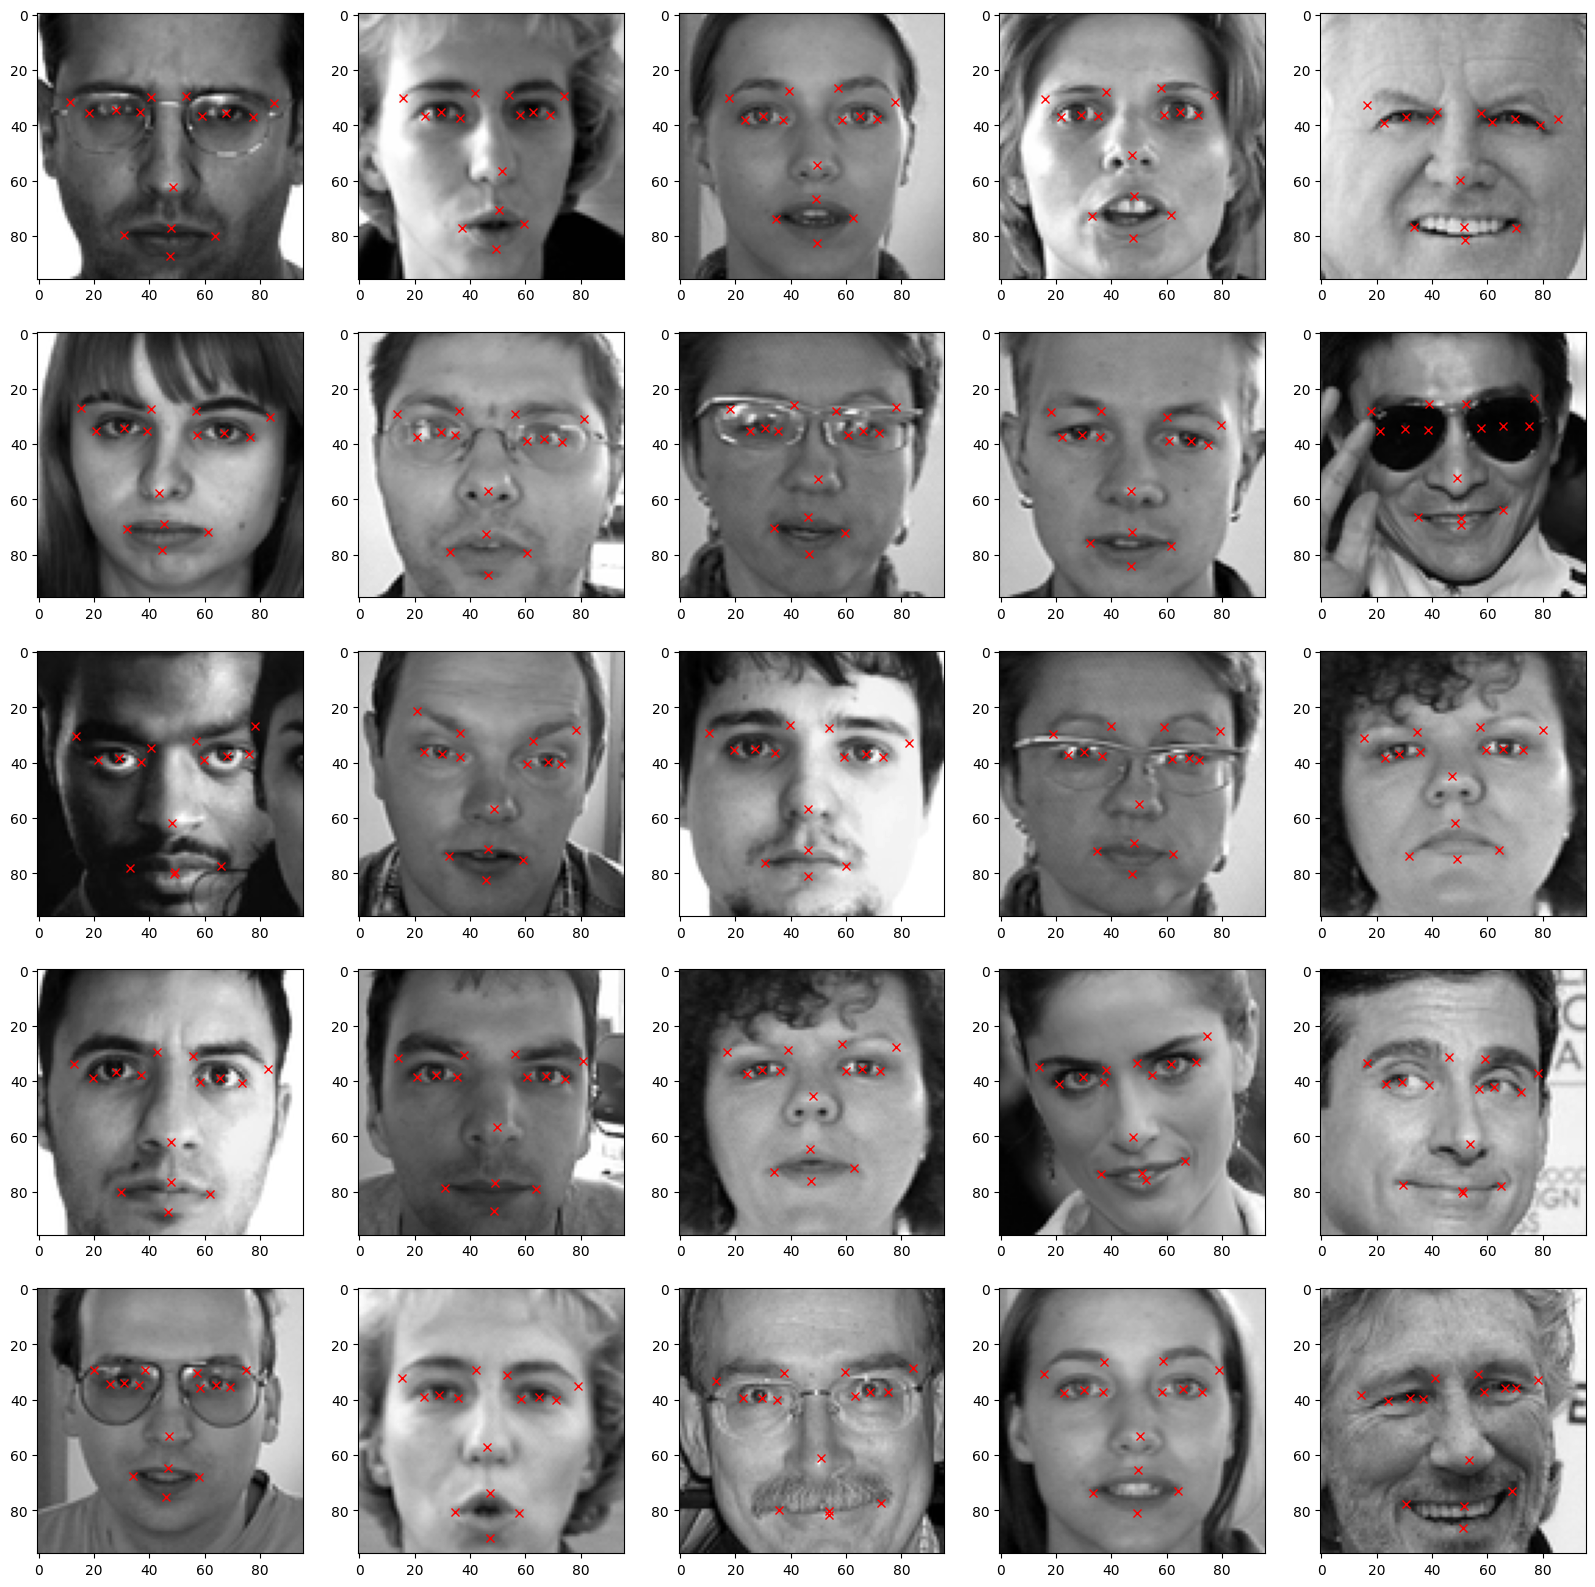

In [12]:
## Plot 25 random image from the dataset along with facial keypoints
# Step 1: define image size
fig = plt.figure(figsize = (20, 20))

# Step 2: show 25 random images
for i in range(0, 25):
  # Step 2-1: define axes
  ax = fig.add_subplot(5, 5, i + 1)
  # Step 2-2: choose a random number
  iImg = np.random.randint(0, len(keyfacial_df))
  # Step 2-3: show gray image
  plt.imshow(keyfacial_df['Image'][iImg], cmap = 'gray')
  # Step 2-4: show key facial points
  for keyPoint in range(0, 30, 2):
    plt.plot(keyfacial_df.loc[iImg][keyPoint], keyfacial_df.loc[iImg][keyPoint+1], 'rx')
  i = i+1

## STEP 3: Image augmentation

In [94]:
# Obtain the columns in the dataframe

columns = keyfacial_df.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [31]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.5],
    fill_mode = "nearest")

## STEP 4: Data normalization

In [32]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = keyfacial_df.iloc[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(2140, 96, 96, 1)

In [33]:
# Obtain the value of x & y coordinates which are to used as target.
y = keyfacial_df.iloc[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(2140, 30)

In [34]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

## STEP 5: Build ResNet key facial points detection model

In [35]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [36]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256,256,1024], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = tf.keras.Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']            

## STEP 6: Compile and train the model

In [37]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])
# Check this out for more information on Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [38]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [46]:
history = model_1_facialKeyPoints.fit(train_datagen.flow(X_train, y_train, batch_size = 64), validation_data = (X_val, y_val), epochs = 100, callbacks=[checkpointer])

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 27.0854 - accuracy: 0.5929
Epoch 1: val_loss improved from 242.37323 to 177.40480, saving model to FacialKeyPoints_weights.hdf5
27/27 [==============================] - 82s 3s/step - loss: 27.0854 - accuracy: 0.5929 - val_loss: 177.4048 - val_accuracy: 0.7523
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 19.8614 - accuracy: 0.5946
Epoch 2: val_loss improved from 177.40480 to 124.51605, saving model to FacialKeyPoints_weights.hdf5
27/27 [==============================] - 92s 3s/step - loss: 19.8614 - accuracy: 0.5946 - val_loss: 124.5161 - val_accuracy: 0.7523
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 21.8332 - accuracy: 0.5818
Epoch 3: val_loss improved from 124.51605 to 67.66549, saving model to FacialKeyPoints_weights.hdf5
27/27 [==============================] - 93s 3s/step - loss: 21.8332 - accuracy: 0.5818 - val_loss: 67.6655 - val_accuracy: 0.7523
Epoch 4/100
27/

In [48]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


## STEP 8: Model assessment

In [49]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [50]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

7/7 [==============================] - 2s 158ms/step - loss: 13.1214 - accuracy: 0.7103
Accuracy : 0.7102803587913513


In [51]:
# Get the model keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

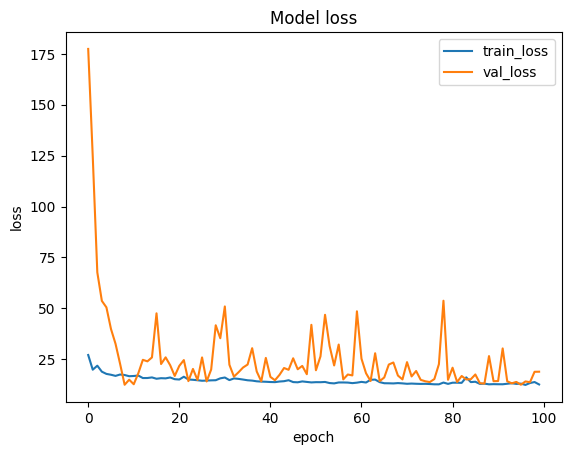

In [52]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# Model 2: Facial expression detection

## STEP 1: Import dataset and visualization

In [53]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('/content/drive/My Drive/Summer2023UW/AI-projects/P96-Section-2-Emotion-AI/Emotion-AI-Dataset/icml_face_data.csv')

In [54]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [55]:
# Resize images from (48, 48) to (96, 96)

def resize(x):

  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [56]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [57]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [58]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [59]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [60]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

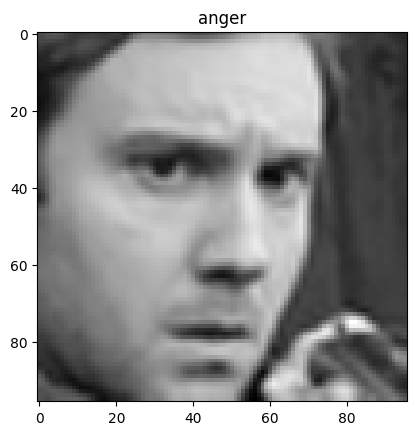

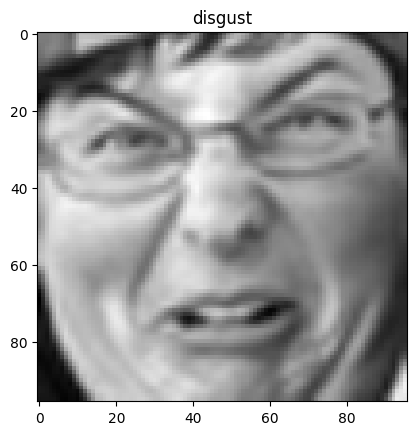

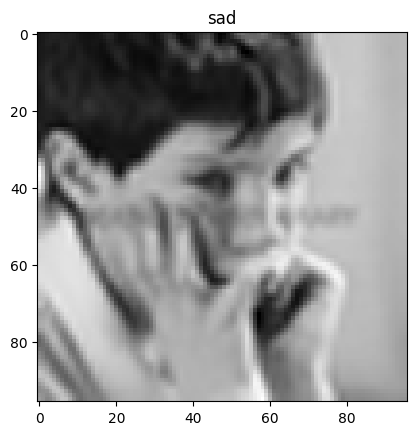

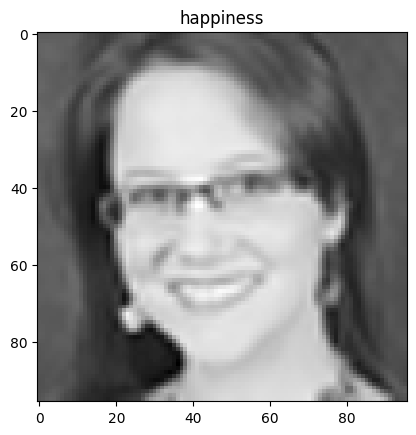

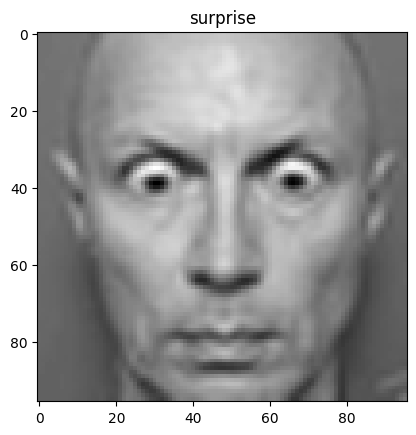

In [61]:
## Visualize images with labels

emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

<Axes: ylabel='emotion'>

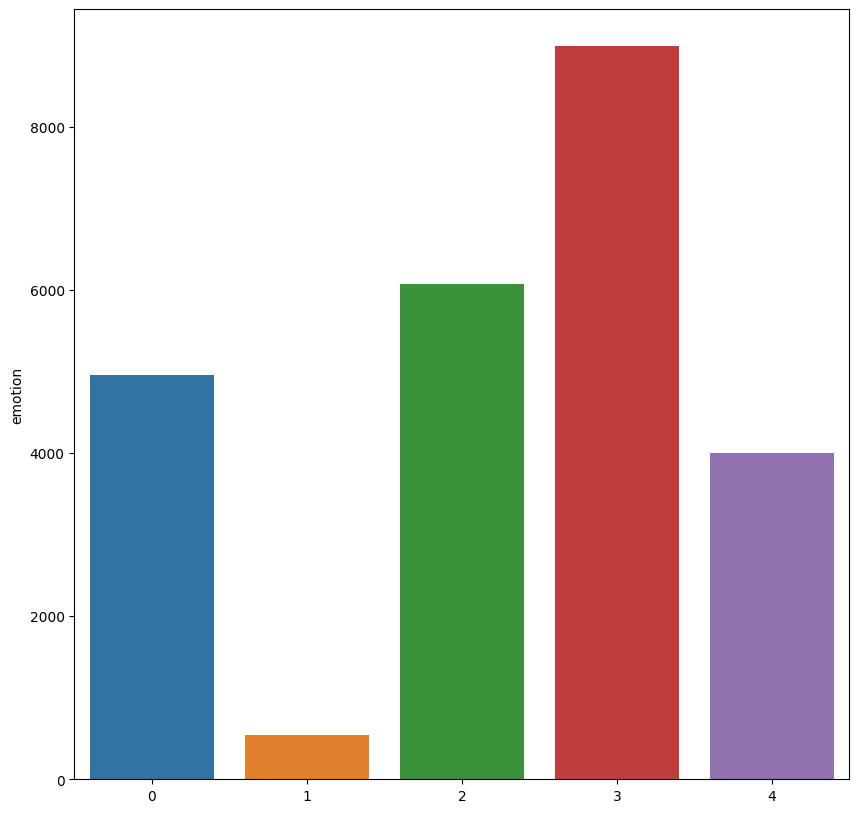

In [62]:
## Examine the number of each category
plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

## STEP 2: Data augmentation

In [63]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])


In [64]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [65]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [66]:
## Data augmentation
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")


In [67]:
## Prepare data into required forms
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [68]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [69]:
# image normalization

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

## STEP 3: Model building and training

In [70]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = tf.keras.Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']           

In [71]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [72]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [74]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 10, callbacks=[checkpointer, earlystopping])

Epoch 1/10
345/345 [==============================] - ETA: 0s - loss: 0.9320 - accuracy: 0.6296
Epoch 1: val_loss improved from inf to 1.22522, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 513s 1s/step - loss: 0.9320 - accuracy: 0.6296 - val_loss: 1.2252 - val_accuracy: 0.4332
Epoch 2/10
345/345 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.6843
Epoch 2: val_loss improved from 1.22522 to 1.16479, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 505s 1s/step - loss: 0.8147 - accuracy: 0.6843 - val_loss: 1.1648 - val_accuracy: 0.4976
Epoch 3/10
345/345 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.7036
Epoch 3: val_loss improved from 1.16479 to 0.84817, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 496s 1s/step - loss: 0.7540 - accuracy: 0.7036 - val_loss: 0.8482 - val_accuracy: 0.6588
Epoch 4/10
345/345 [======

In [75]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

## STEP 4: Model assessment

In [76]:
with open('FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialExpression_weights.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [77]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 8s 161ms/step - loss: 0.7031 - accuracy: 0.7258
Test Accuracy: 0.7257933020591736


In [78]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [79]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

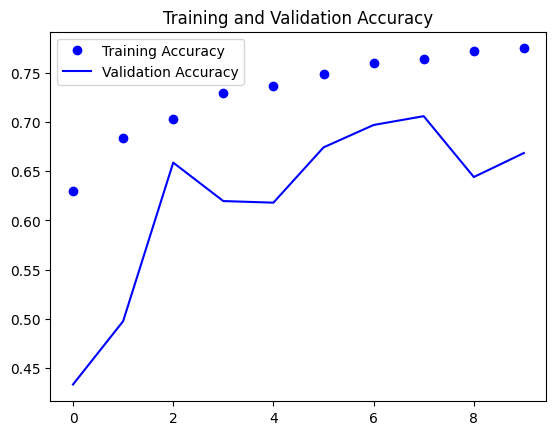

In [80]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

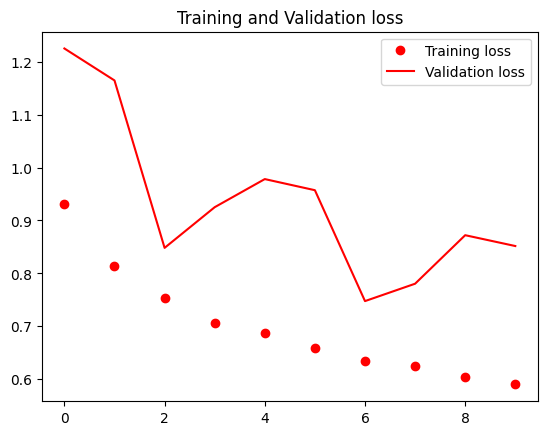

In [81]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [82]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 [==============================] - 8s 198ms/step


<Axes: >

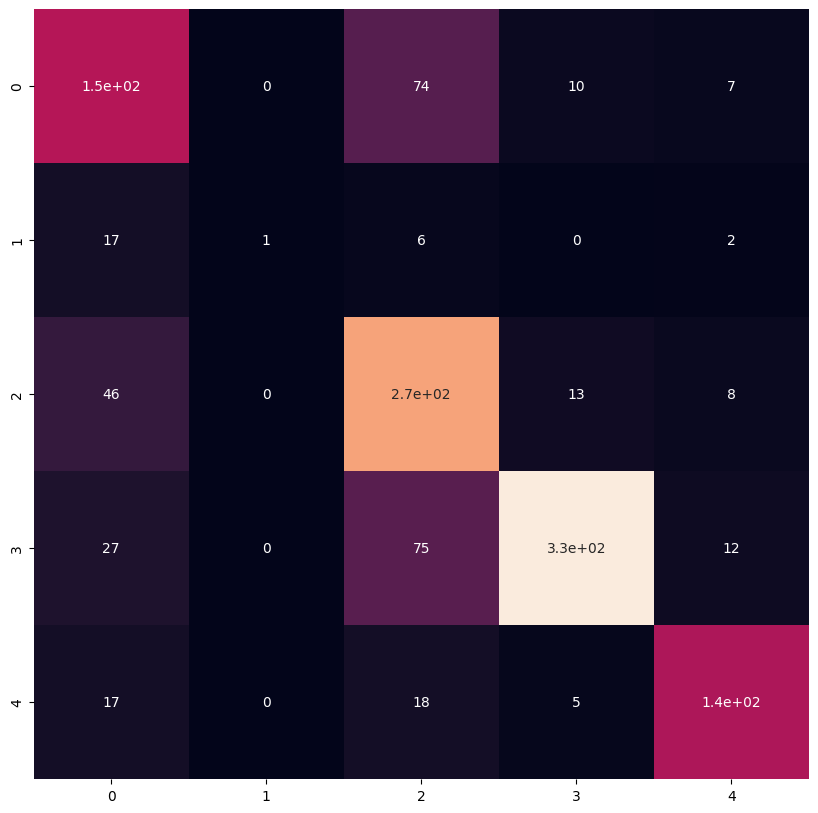

In [83]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

# Compile and deploy Model 1 and 2

## STEP 1: combine facial key points detection model and facial expression model

In [95]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [96]:
df_predict = predict(X_test)

7/7 [==============================] - 1s 140ms/step


In [97]:
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,64.907913,35.275578,28.311985,34.710712,56.845638,35.008934,71.619949,35.747211,36.152977,36.146584,...,55.524422,62.840008,74.439178,30.760021,74.131790,46.137127,70.506172,44.825657,80.236320,4
1,64.953079,35.288666,28.151381,34.783115,56.626789,34.846569,71.712563,35.714588,36.178448,36.370026,...,55.859478,62.465046,74.561684,30.614061,73.806824,45.511246,70.562019,44.592300,80.139198,3
2,64.955276,35.178940,27.967419,34.763596,56.370377,34.813438,71.446739,35.721214,36.193565,36.256386,...,55.532166,62.286751,74.400002,30.398750,73.656601,45.328674,70.633781,44.382805,80.060234,2
3,65.841492,35.996025,28.671843,35.301792,57.605106,35.516701,72.678612,36.436882,36.814915,36.656357,...,56.530220,63.543095,75.503258,31.143791,75.102448,46.562420,71.657707,45.243710,81.439384,4
4,65.085846,35.640057,27.944151,34.728622,55.882610,34.839371,71.086258,35.896156,36.108910,36.894367,...,56.528183,62.215214,74.439995,30.445726,73.937805,44.424419,71.622116,44.820030,80.336548,0


## STEP 2: Deploy both trained models

In [98]:
import json
import tensorflow.keras.backend as K

def deploy(directory, model):
  MODEL_DIR = directory
  version = 1

  # Let's join the temp model directory with our chosen version number
  # The expected result will be = '\tmp\version number'
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Let's save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm'
  # rm removes each file specified on the command line.

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

In [99]:
# Let's add tensorflow-model-server package to our list of packages
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   7694      0 --:--:-- --:--:-- --:--:--  7704
OK
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]


In [100]:
# Let's install tensorflow model server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 438 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.13.0 [438 MB]
Fetched 438 MB in 11s (41.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.13.0_all.deb ...
Unpacking tensorflow-model-server (2.13.0) ...
Setting up tensorflow-model-server (2.13.0) ...


In [101]:
deploy('/model', model_1_facialKeyPoints)

export_path = /model/1



In [102]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [103]:
!tail server.log

In [104]:
deploy('/model1', model_2_emotion)

export_path = /model1/1



In [105]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [106]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## STEP 3: Make request in Tensorflow serving

In [107]:
import json

# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 7], [0.23529411852359772], [0.23529411852359772]]]]}


In [108]:
!pip install -q requests

In [109]:
import requests

# Function to make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [110]:
# making prediction
df_predict = response(data)

In [111]:
df_predict

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,64.907913,35.275581,28.311989,34.710716,56.845646,35.008934,71.619957,35.747211,36.152977,36.146576,...,55.524425,62.840012,74.439194,30.760021,74.131790,46.137119,70.506172,44.825653,80.236321,4
1,64.953079,35.288662,28.151380,34.783123,56.626793,34.846573,71.712570,35.714596,36.178448,36.370029,...,55.859493,62.465054,74.561684,30.614063,73.806824,45.511249,70.562019,44.592312,80.139200,3
2,64.955284,35.178940,27.967419,34.763596,56.370388,34.813446,71.446754,35.721222,36.193565,36.256393,...,55.532173,62.286755,74.400017,30.398756,73.656609,45.328678,70.633800,44.382812,80.060234,2


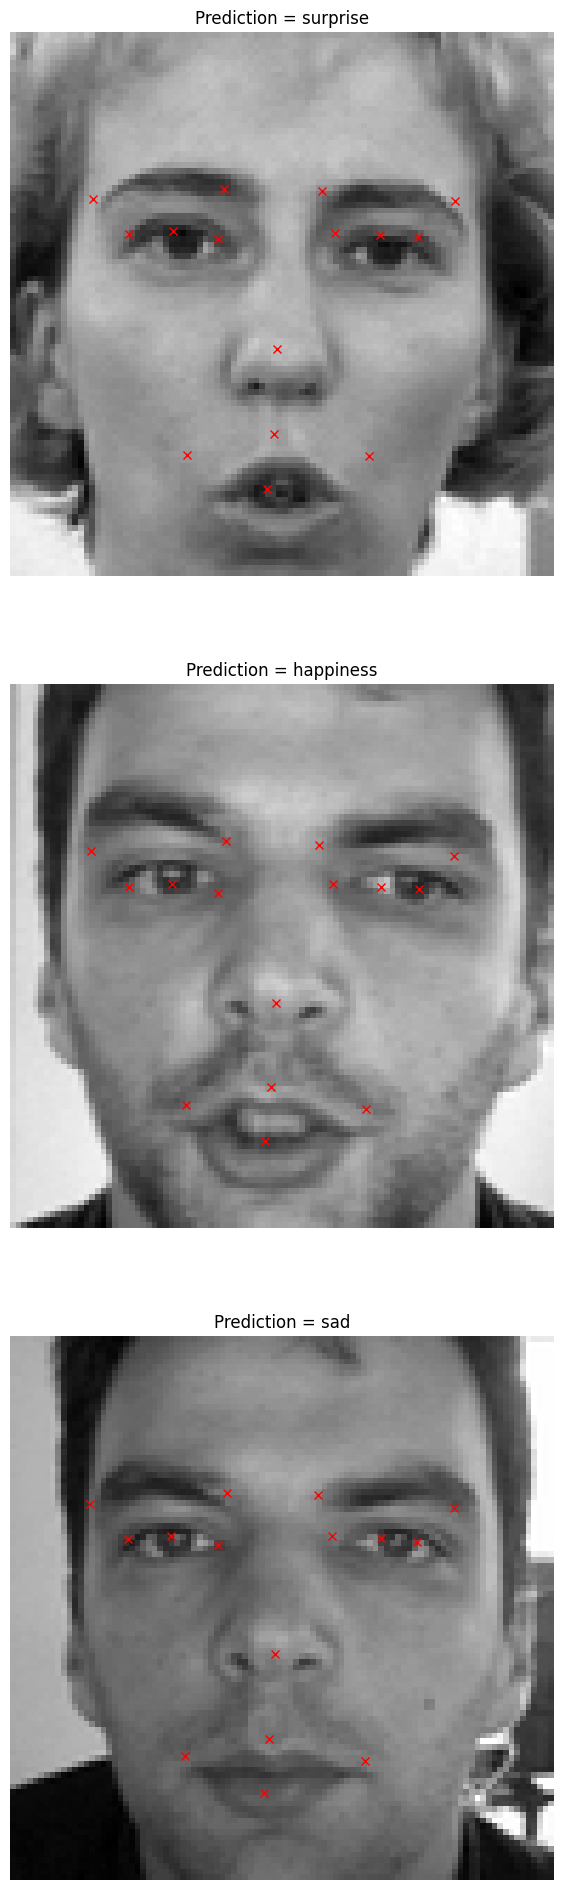

In [112]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
